In [1]:
from torch.utils.data import Dataset
import os
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,random_split
from torchvision.transforms import transforms as T
from torch import optim
import numpy as np
from PIL import Image
import random
from scipy import ndimage, io, misc
import shutil  
import torchvision.models as models
from tqdm import tqdm
from xml.dom import minidom
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
test_list = io.loadmat('test_list.mat')['file_list']
train_list = io.loadmat('train_list.mat')['file_list']

In [ ]:
for folder in os.listdir('Images'):
    os.makedirs("train/"+folder.split("\\")[-1].split("-",1)[-1])
    os.makedirs("test/"+folder.split("\\")[-1].split("-",1)[-1])

In [ ]:
# original images
def move_data_files(image_list, new_folder):
    for file in image_list:
        if os.path.exists('Images/'+file[0][0]):
            folder_name = file[0][0].split("/")[0].split("-",1)[-1]
            file_name = file[0][0].split("/")[1]
            shutil.move('Images/'+file[0][0],new_folder+'/'+folder_name+'/'+file_name)
        elif not os.path.exists(new_folder+'/'+file[0][0]):
           print('%s does not exist, it may be missing' % os.path.exists('./images/'+file[0][0]))
    return [new_folder+'/'+d for d in sorted(os.listdir(new_folder)) if os.path.isdir(os.path.join(new_folder, d))]

In [ ]:
# crop images
def crop_image(image_list,new_folder):
    count = 0
    for file in image_list:
        if os.path.exists('Images/'+file[0][0]):
            folder_name = file[0][0].split("/")[0].split("-",1)[-1]
            file_name = file[0][0].split("/")[1]
            annon_xml = minidom.parse('Annotation/'+file[0][0].split('.')[0])
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            img = cv2.imread('Images/'+file[0][0])
            cropped_img = img[ymin:ymax,xmin:xmax,:]
            cv2.imwrite(new_folder+'/'+folder_name+'/'+file_name,cropped_img)
 

In [ ]:
crop_image(train_list, 'train')
crop_image(test_list, 'test')

In [ ]:
# test_folders = move_data_files(test_list, 'test')
# train_folders = move_data_files(train_list, 'train')

In [2]:
class ResNet(nn.Module):
    def __init__(self, num_classes=120, pretrained = True):
        super(ResNet, self).__init__()
        self.net = models.resnet50(pretrained=pretrained)
        num_ftrs = self.net.fc.in_features
        self.net.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
        )

    def forward(self, x):
        return self.net(x)

In [3]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=120, pretrained = True):
        super(VGGNet, self).__init__()
        net = models.vgg16_bn(pretrained=pretrained)
#         pre=torch.load('vgg16_bn-6c64b313.pth')
#         net.load_state_dict(pre)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [4]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes=120, pretrained = True):
        super(GoogleNet, self).__init__()
        self.net = models.googlenet(pretrained=pretrained)
        num_ftrs = self.net.fc.in_features
        self.net.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120, bias=True),
        )

    def forward(self, x):
        return self.net(x)

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes=120):
        super(CNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),   # 224 * 244 * 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),                                   
            nn.MaxPool2d(4, 4),                         # 56 * 56 * 64

            nn.Conv2d(64, 128, 3, stride=1, padding=1),    # 56 * 56* 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4,4),                          # 14 * 14* 128

            nn.Conv2d(128, 256, 3, stride=1, padding=1),   # 14*14*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),                        # 7*7*256
            
            nn.Flatten(),
            nn.Linear(7*7*256, 512),
            nn.ReLU(True),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Linear(128, num_classes))

            
    def forward(self, x):
        return self.network(x)
        
                

In [6]:
ResNet().cuda()

ResNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [7]:
image_length = 224
train_transform=T.Compose([
#                     T.RandomResizedCrop(image_length),
#                     T.RandomHorizontalFlip(),
#                     T.RandomCrop(224, padding=2, padding_mode='reflect'),
#                     T.RandomRotation(degrees=20),
                    T.Resize((image_length,image_length)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
                         )
test_transform = T.Compose([T.Resize((image_length,image_length)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
                          )

In [8]:
batch_size = 32
datasets   = torchvision.datasets.ImageFolder('train_new',train_transform)
# datasets   = torchvision.datasets.ImageFolder('train',train_transform)
train_size = int(len(datasets)*0.8)
val_size = len(datasets) - train_size
train_datasets,val_datasets = random_split(datasets, [train_size, val_size])
train_dataloader = torch.utils.data.DataLoader(train_datasets , batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_datasets , batch_size=100)
test_datasets   = torchvision.datasets.ImageFolder('test',test_transform)
test_dataloader = torch.utils.data.DataLoader(test_datasets , batch_size=1)

In [9]:
len(train_datasets),len(val_datasets),len(test_datasets)

(52679, 13170, 8580)

In [10]:
def accuracy(output, labels):
    pred = torch.max(output, dim=1)[1]
    return (pred == labels).sum().item()/ len(labels)

In [13]:
def train_epoch(model, train_dataloader, optimizer, loss_func, train_loss_list, train_accuracy_list):
    train_loss = 0.
    train_acc = 0.
    model.train()
    for batch_x, batch_y in tqdm(train_dataloader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        out = model(batch_x)
        loss = loss_func(out, batch_y)
        train_loss += loss.item()
        train_acc += accuracy(out, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(
    train_dataloader)), train_acc / (len(train_dataloader))))
    train_loss_list.append(train_loss / (len(train_dataloader)))
    train_accuracy_list.append(train_acc / (len(train_dataloader)))
    return train_loss_list, train_accuracy_list

In [12]:
# mixup augmentation
def train_epoch(model, train_dataloader, optimizer, criterion, train_loss_list, train_accuracy_list):
    train_loss = 0.
    train_acc = 0.
    model.train()
    for batch_x, batch_y in tqdm(train_dataloader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        alpha=1
        lam = np.random.beta(alpha,alpha)
        index = torch.randperm(batch_x.size(0)).cuda()
        inputs = lam*batch_x + (1-lam)*batch_x[index,:]
        batch_y_a, batch_y_b = batch_y, batch_y[index]
        outputs = model(inputs)
        loss = lam * criterion(outputs, batch_y_a) + (1 - lam) * criterion(outputs, batch_y_b)
        train_loss += loss.item()
        train_acc += lam * accuracy(outputs, batch_y_a) + (1 - lam) * accuracy(outputs, batch_y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(
    train_dataloader)), train_acc / (len(train_dataloader))))
    train_loss_list.append(train_loss / (len(train_dataloader)))
    train_accuracy_list.append(train_acc / (len(train_dataloader)))
    return train_loss_list, train_accuracy_list

In [16]:
def val_epoch(model, test_dataloader, optimizer, loss_func, test_loss_list, test_accuracy_list, best_test_accuracy):
    model.eval()
    with torch.no_grad():
        test_loss = 0.
        test_acc = 0.
        for batch_x, batch_y in tqdm(test_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            out = model(batch_x)
            loss = loss_func(out, batch_y)
            test_loss += loss.item()
            test_acc += accuracy(out, batch_y)
        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(test_loss / (len(
        test_dataloader)), test_acc / (len(test_dataloader))))
        test_loss_list.append(test_loss / (len(test_dataloader)))
        test_accuracy_list.append(test_acc / (len(test_dataloader)))
        if (test_acc / (len(test_dataloader))) > best_test_accuracy:
            best_test_accuracy = test_acc / (len(test_dataloader))
            torch.save(model.state_dict(),"cnn_large.pth")
    return test_loss_list, test_accuracy_list, best_test_accuracy

In [17]:
def test_result(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        test_acc = 0.
        for batch_x, batch_y in tqdm(test_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            out = model(batch_x)
            test_acc += accuracy(out, batch_y)
        print('Test Acc: {:.6f}'.format(test_acc / (len(test_dataloader))))

In [21]:
epoch = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = VGGNet().to(device)
# model = ResNet(pretrained=True).to(device)
# model = GoogleNet().to(device)
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),1e-4)

In [22]:
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
best_test_accuracy = 0

for epoch in range(epoch):
    print('epoch {}'.format(epoch + 1))
    train_loss_list, train_accuracy_list = train_epoch(model, train_dataloader, \
                                                       optimizer, loss_func, train_loss_list, train_accuracy_list)
    test_loss_list, test_accuracy_list, best_test_accuracy = val_epoch(model, val_dataloader, \
                                                optimizer, loss_func, test_loss_list, test_accuracy_list, best_test_accuracy)
test_result(model, test_dataloader)

epoch 1



Train Loss: 3.704267, Acc: 0.161403



Test Loss: 3.381022, Acc: 0.195866
epoch 2



Train Loss: 3.082951, Acc: 0.252185



Test Loss: 3.055865, Acc: 0.253874
epoch 3



Train Loss: 2.739576, Acc: 0.315864



Test Loss: 2.918191, Acc: 0.278074
epoch 4



Train Loss: 2.494716, Acc: 0.363364



Test Loss: 2.639205, Acc: 0.330152
epoch 5



Train Loss: 2.278357, Acc: 0.409139



Test Loss: 2.567123, Acc: 0.352370
epoch 6



Train Loss: 2.096015, Acc: 0.450896



Test Loss: 2.531992, Acc: 0.360595
epoch 7



Train Loss: 1.922823, Acc: 0.489445



Test Loss: 2.392444, Acc: 0.385844
epoch 8



Train Loss: 1.758322, Acc: 0.528680



Test Loss: 2.427585, Acc: 0.388474
epoch 9



Train Loss: 1.605113, Acc: 0.565143



Test Loss: 2.343486, Acc: 0.404545
epoch 10



Train Loss: 1.447368, Acc: 0.606381



Test Loss: 2.307566, Acc: 0.419102



Test Acc: 0.330653


In [24]:
# googlemodel = GoogleNet().to(device)
# googlemodel.eval()
# googlemodel.load_state_dict(torch.load('google_large.pth'))
# test_result(googlemodel, test_dataloader)


Test Acc: 0.857226


In [37]:
def get_breed_and_accuracy(out):
    probabilities = F.softmax(out, dim=1) 
    breed = torch.max(out, dim=1)[1]
    breed_prob = torch.max(probabilities[0])
    return breed, breed_prob

def get_final_predict(vggout, googleout, resout):
    size = len(vggout)
    vgg_breed, vgg_prob = get_breed_and_accuracy(vggout)
    google_breed, google_prob = get_breed_and_accuracy(vggout)
    resbreed, res_prob = get_breed_and_accuracy(resout)
    if vgg_breed == google_breed or vgg_breed == resbreed:
        result = vgg_breed
    elif google_breed == resbreed:
        result = google_breed
    else:
        arr = [vgg_breed, google_breed, resbreed]
        prob_arr = np.array([vgg_prob, google_prob, res_prob])
        result=arr[prob_arr.argmax()]
    return result

def test_model_with_major_vote():
    resmodel = ResNet().to(device)
    resmodel.eval()
    resmodel.load_state_dict(torch.load('resnet_large.pth'))
    googlemodel = GoogleNet().to(device)
    googlemodel.eval()
    googlemodel.load_state_dict(torch.load('google_large.pth'))
    vggmodel = VGGNet().to(device)
    vggmodel.eval()
    vggmodel.load_state_dict(torch.load('vggnet_large.pth'))
#     vggmodel.load_state_dict(torch.load('weight_1_best.pth'))
#     inv_map = {v: k for k, v in test_datasets.class_to_idx.items()}

    res = np.zeros((120, 120))
    total = np.zeros(120)
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            vggout = vggmodel(batch_x)
            googleout = googlemodel(batch_x)
            resout = resmodel(batch_x)
#             vgg_breed, vgg_prob = get_breed_and_accuracy(vggout)
#             google_breed, google_prob = get_breed_and_accuracy(googleout)
#             res_breed, google_prob = get_breed_and_accuracy(resout)
            pred = get_final_predict(vggout, googleout, resout)
            total[batch_y.item()] += 1
#             if (pred == batch_y).item():
            res[batch_y.item()][pred.item()] += 1
    return res, total
#             (pred == labels).sum().item()/ len(labels)
#             total[batch_y.item()] = total[batch_y.item()] + 1
#             if correct:
#                 res[batch_y.item()] = res[batch_y.item()] + 1

In [38]:
res, total = test_model_with_major_vote()

In [40]:
res.diagonal().sum() / total.sum()

0.8111888111888111

In [41]:
res.sum(axis=0)
mispredict = res.sum(axis=0) - res.diagonal()
mispredict.argmax()

24

In [42]:
mispredict[mispredict.argmax()]

71.0

In [43]:
inv_map = {v: k for k, v in test_datasets.class_to_idx.items()}
inv_map[mispredict.argmax()]

'Eskimo_dog'

In [44]:
res[mispredict.argmax(), mispredict.argmax()]

38.0

In [45]:
res[:, mispredict.argmax()]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 38.,  0.,
        2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., 27.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.])

In [46]:
temp = res.copy()
np.fill_diagonal(temp, 0)

In [47]:
idx = np.argpartition(-temp.ravel(),3)[:3]
top_3 = np.column_stack(np.unravel_index(idx, temp.shape))
top_3

array([[101,  24],
       [ 64,  24],
       [ 37, 118]], dtype=int64)

In [48]:
print(inv_map[top_3[0][0]])
print(inv_map[top_3[0][1]])
print(inv_map[top_3[1][0]])
print(inv_map[top_3[1][1]])
print(inv_map[top_3[2][0]])
print(inv_map[top_3[2][1]])

malamute
Eskimo_dog
Siberian_husky
Eskimo_dog
Italian_greyhound
whippet


In [49]:
np.sort(temp, axis=None)

array([ 0.,  0.,  0., ..., 22., 27., 29.])

In [50]:
print(res[top_3[0][0], top_3[0][1]])
print(res[top_3[1][0], top_3[1][1]])
print(res[top_3[2][0], top_3[2][1]])


29.0
27.0
22.0


In [ ]:
image_path = './low-resolution'
dataset = []
for element in os.listdir(image_path):
    for img_id in os.listdir(os.path.join(image_path, element)):
        path = os.path.join(element, img_id)
        label = element.split('-')[2]
        dataset.append((path, label))
df = pd.DataFrame(dataset, columns = ['Path', 'Label'])
for i in range(len(df)):
    path = df.iloc[i][0]
    #print(image_path+'/'+path)
    original_path = image_path+'/'+path
    #img = Image.open(image_path+'/'+path).convert('RGB')
    #plt.imshow(img)
    img_trans  = test_transform(img)
    out = model(img_trans.unsqueeze(0))
    probabilities = F.softmax(out,dim=1) 
    breed = inv_map[torch.max(out, 1)[1].item()]
    breed_prob = torch.max(probabilities[0])
    print(breed)
    print(torch.max(probabilities[0]))
    if breed_prob > 0.8:
        des_path = './train/' + breed
        #print(des_path)
        shutil.copy(original_path,des_path)

In [59]:
correct = res.diagonal()
best_10 = []
best_10_acc = []
worst_10 = []
worst_10_acc = []
accuarcy_per_group = np.round(correct/total,4)
sorted_ascend = accuarcy_per_group.argsort()
sorted_descend = accuarcy_per_group.argsort()[::-1]

for i in range(10):
    best_10.append(inv_map[sorted_descend[i]])
    best_10_acc.append(accuarcy_per_group[sorted_descend[i]])
    worst_10.append(inv_map[sorted_ascend[i]])
    worst_10_acc.append(accuarcy_per_group[sorted_ascend[i]])
print(best_10)
print(best_10_acc)
print(worst_10)
print(worst_10_acc)

['golden_retriever', 'Afghan_hound', 'papillon', 'Samoyed', 'komondor', 'clumber', 'Irish_water_spaniel', 'Norwegian_elkhound', 'West_Highland_white_terrier', 'Ibizan_hound']
[0.98, 0.9784, 0.9688, 0.9661, 0.963, 0.96, 0.96, 0.9583, 0.9565, 0.9545]
['collie', 'malamute', 'Staffordshire_bullterrier', 'miniature_poodle', 'standard_poodle', 'Eskimo_dog', 'Irish_wolfhound', 'Appenzeller', 'Lhasa', 'Australian_terrier']
[0.3208, 0.3846, 0.4182, 0.4364, 0.4746, 0.5, 0.5254, 0.5294, 0.5581, 0.5625]


(0.0, 1.0)

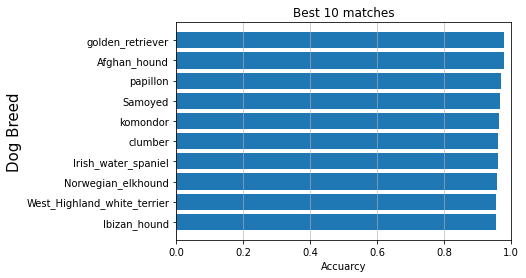

In [61]:
#visualize best 10 matches
plt.barh(best_10[::-1], best_10_acc[::-1]) 
plt.grid(axis='x', alpha=0.75)
# plt.yticks(x, best_10[::-1])
plt.ylabel('Dog Breed',fontsize=15)
plt.xlabel('Accuarcy',fontsize=10)
plt.title("Best 10 matches")
plt.xlim(0, 1)

(0.0, 1.0)

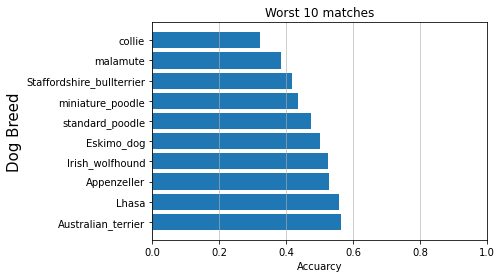

In [62]:
#visualize worst 10 matches
plt.barh(worst_10[::-1], worst_10_acc[::-1]) 
plt.grid(axis='x', alpha=0.75)
# plt.yticks(x, worst_10[::-1])
plt.ylabel('Dog Breed',fontsize=15)
plt.xlabel('Accuarcy',fontsize=10)
plt.title("Worst 10 matches")
plt.xlim(0, 1)